# Import Libraries

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import os
from os import path
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
import textblob

# Read in Saved Cleaned Reviews

In [2]:
df_com_full = pd.read_pickle('./Drugs_Com_Full_cleaned.pk')
df_lib_full = pd.read_pickle('./Drugs_Lib_Full_cleaned.pk')

# Sentiment Analysis

TextBlob is a really easy package to use for a lot of natural language processing tasks. For sentiment analysis, it relies on a lexicon, not a ML algorithm, to define its word properties. This [website](https://planspace.org/20150607-textblob_sentiment/) gives a good introduction to the package. Each word in the review is given a polarity score with -1 being the maximum negative value and +1 being the maximum positive value. An average of all the words' polarity scores within the review are taken to calculate the final score. A similar method is used for the subjectivity score; 0 indicates there is no subjectivity within the review and it is basically stating facts while a score of +1 indicates that the review is mostly an opinion.

In [3]:
def tb_sent_analyzer(review):
    tb = textblob.TextBlob(review) # textblob takes a string and does the tokenization internally
    score_pol = tb.sentiment.polarity # [-1.0 (negative), 1.0 (positive)]
    score_sub = tb.sentiment.subjectivity # [0 (fact), 1 (opinion)]
    return score_pol, score_sub

In [4]:
# send drugs.com set to tb function
df_com_full['score_pol'], df_com_full['score_sub']=zip(*df_com_full['review_clean'].apply(tb_sent_analyzer))

# send drugs lib set to tb function
df_lib_full['b_score_pol'], df_lib_full['b_score_sub']=zip(*df_lib_full['benefits_clean'].apply(tb_sent_analyzer))
df_lib_full['se_score_pol'], df_lib_full['se_score_sub']=zip(*df_lib_full['sideEffects_clean'].apply(tb_sent_analyzer))
df_lib_full['c_score_pol'], df_lib_full['c_score_sub']=zip(*df_lib_full['comments_clean'].apply(tb_sent_analyzer))

First I tried to do the sentiment analysis on the test and training sets individually, however, from insights gained during EDA, the data is well distributed between the two sets so keeping the sets separate for the sentiment analysis portion is unnessecary. I also tried to run the analysis on the un-cleaned version of the text to see if there were any differences due to stopword removal or lemmatization. My analysis showed that there were insignificant differences so I chose to continue forward with the cleaned version of the text.

## Polarity vs. Subjectivity

### Drugs.com Dataset

#### Distributions

In [5]:
# plot the distribution of sentiment: polarity and subjectivities
def plot_sent(pol_scores, sub_scores, title):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    f.suptitle(title, fontsize=14)
        
    n_bins = 30
    
    ax1.hist(pol_scores, facecolor='b', alpha=0.75, bins=n_bins)
    ax1.set(ylabel='Review Counts', xlabel='Polarity Score', 
            xlim=(-1.0,1.0), title='Review Polarity Distribution')
    # plotting mean code from here:https://stackoverflow.com/questions/16180946/drawing-average-line-in-histogram-matplotlib
    ax1.axvline(pol_scores.mean(), color='k', linestyle='dashed', linewidth=2) 
    _, max_ = plt.ylim()
    ax1.text(pol_scores.mean() + pol_scores.mean(), max_ - max_/10,'Mean: {:.2f}'.format(pol_scores.mean()))

    ax2.hist(sub_scores, facecolor='b', alpha=0.75, bins=n_bins)
    ax2.set(xlabel='Subjectivity Score', xlim=(0.0,1.0),
            title='Review Subjectivity Distribution')
    ax2.axvline(sub_scores.mean(), color='k', linestyle='dashed', linewidth=2)
    _, max_ = plt.ylim()
    ax2.text(sub_scores.mean() + sub_scores.mean()/30, max_ - max_/10,'Mean: {:.2f}'.format(sub_scores.mean()))

    plt.show()
    return

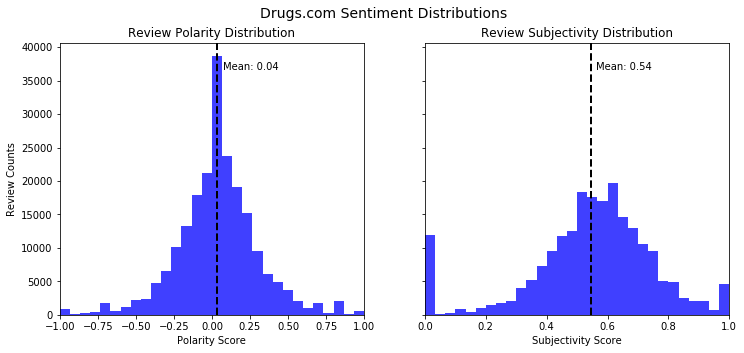

In [6]:
plot_sent(df_com_full['score_pol'], df_com_full['score_sub'], 'Drugs.com Sentiment Distributions')

The Drugs.com dataset is normally distributed with regards to the polarity of the reviews. It has a slightly positive leaning with a mean of 0.04, however, it is very minimal and there are almost an equal number of reviews classified as positive as there are negative ones. For the subjectivity distribution, it also shows a fairly nomral distribution, except there are larger peaks at the limits (completely opinion vs. completely fact). The mean of the subjectivity scores is 0.54 meaning that most of the reviews are determined to be about half fact and half opinion.  

#### Polarity and Subjectivity by Rating

Instead of looking at the entire distribution of sentiments, I drill down and look at the distributions by ratings. 

In [7]:
def pol_by_rating(rating, polarity, title):
    fig, ax = plt.subplots(figsize=(12,5), sharex=True)
    sns.boxenplot(x=rating, y=polarity, ax=ax)
    ax.set_xlabel('Rating')
    ax.set_ylabel('Sentiment Polarity')
    plt.title(title, fontsize=14)
    plt.show()
    return

In [8]:
def sub_by_rating(rating, subject, title):
    fig, ax = plt.subplots(figsize=(12,5), sharex=True)
    sns.boxenplot(x=rating, y=subject, ax=ax)
    ax.set_xlabel('Rating')
    ax.set_ylabel('Sentiment Subjectivity')
    plt.title(title, fontsize=14)
    plt.show()
    return

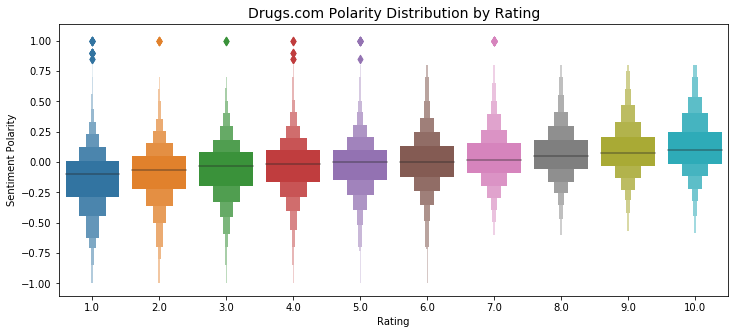

In [9]:
pol_by_rating(df_com_full['rating'], df_com_full['score_pol'], 'Drugs.com Polarity Distribution by Rating')

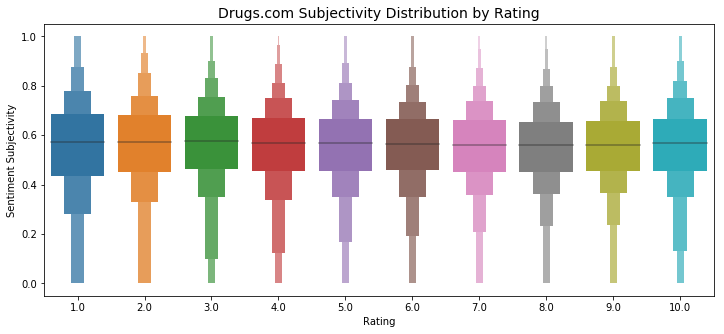

In [10]:
sub_by_rating(df_com_full['rating'], df_com_full['score_sub'], 'Drugs.com Subjectivity Distribution by Rating')

It is a very slight difference between a rating of 1 and a rating of 10, however there is a positive slope, the average polarity increases as the rating increases. For the subjectivity, the ratings seem to have no effect on the level of fact or opinion in the review.

#### Examples

In [11]:
print('Example Subjectivity = 1 (opinion):\n',df_com_full['review'].loc[df_com_full['score_sub']==1][33])
print('\nExample Subjectivity = 0 (fact):\n',df_com_full['review'].loc[df_com_full['score_sub']==0][191])
print('\nExample Polarity = 1 (positive):\n',df_com_full['review'].loc[df_com_full['score_pol']==1][830])
print('\nExample Polarity = -1 (negative):\n',df_com_full['review'].loc[df_com_full['score_pol']==-1][303])

Example Subjectivity = 1 (opinion):
 "The burning is out of control about 20 minutes after inserting it . Sat in the bath trying to get this stuff out . This is awful"

Example Subjectivity = 0 (fact):
 "I had my first atrial fibrillation crisis 3 moths ago. They cardioverted me, the doctor put me on metoprolol succinate ER 25mg for the first month and now I'm on on metoprolol tartrate 25mg. "

Example Polarity = 1 (positive):
 "Excellent medication for bipolar disorder although I had a reaction to it."

Example Polarity = -1 (negative):
 "I have been suffering from terrible allergies due to hay fever.  The allergies caused horrible headaches.  Doctor gave me a prescription for butalbital (Fioricet). It helped so much. I was taking Excedrin migraine however it was keeping me up at night. Everyone who suffers must try it. It is inexpensive compared to most migraine medications."


### Drugs Lib Dataset

#### Distributions

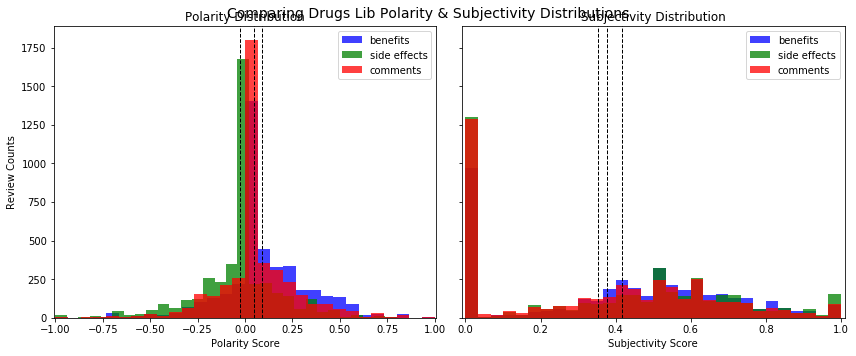

Benefits Polarity Mean: 0.09
Side Effects Polarity Mean: -0.03
Comments Polarity Mean: 0.05

Benefits Subjectivity Mean: 0.42
Side Effects Subjectivity Mean: 0.38
Comments Subjectivity Mean: 0.35


In [12]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
labels = ['Benefits', 'Side Effects', 'Comments']
f.suptitle('Comparing Drugs Lib Polarity & Subjectivity Distributions', fontsize=14)

n_bins = 30

# polarity graph
ax1.hist(df_lib_full['b_score_pol'], facecolor='b', alpha=0.75, bins=n_bins, label='benefits')
ax1.axvline(df_lib_full['b_score_pol'].mean(), color='k', linestyle='dashed', linewidth=1) 

ax1.hist(df_lib_full['se_score_pol'], facecolor='g', alpha=0.75, bins=n_bins, label='side effects')
ax1.axvline(df_lib_full['se_score_pol'].mean(), color='k', linestyle='dashed', linewidth=1) 

ax1.hist(df_lib_full['c_score_pol'], facecolor='r', alpha=0.75, bins=n_bins, label='comments')
ax1.axvline(df_lib_full['c_score_pol'].mean(), color='k', linestyle='dashed', linewidth=1) 

ax1.set(ylabel='Review Counts', xlabel='Polarity Score', 
        xlim=(-1.01,1.01), title='Polarity Distribution')
ax1.legend()

# subjectivity graph
ax2.hist(df_lib_full['b_score_sub'], facecolor='b', alpha=0.75, bins=n_bins, label='benefits')
ax2.axvline(df_lib_full['b_score_sub'].mean(), color='k', linestyle='dashed', linewidth=1) 

ax2.hist(df_lib_full['se_score_sub'], facecolor='g', alpha=0.75, bins=n_bins, label='side effects')
ax2.axvline(df_lib_full['se_score_sub'].mean(), color='k', linestyle='dashed', linewidth=1) 

ax2.hist(df_lib_full['c_score_sub'], facecolor='r', alpha=0.75, bins=n_bins, label='comments')
ax2.axvline(df_lib_full['c_score_sub'].mean(), color='k', linestyle='dashed', linewidth=1) 

ax2.set(xlabel='Subjectivity Score', 
        xlim=(-0.01,1.01), title='Subjectivity Distribution')
ax2.legend()

f.tight_layout()
plt.show()


print('Benefits Polarity Mean: {0:.2f}\nSide Effects Polarity Mean: {1:.2f}\nComments Polarity Mean: {2:.2f}'.format(df_lib_full['b_score_pol'].mean(), df_lib_full['se_score_pol'].mean(), df_lib_full['c_score_pol'].mean()))
print('\nBenefits Subjectivity Mean: {0:.2f}\nSide Effects Subjectivity Mean: {1:.2f}\nComments Subjectivity Mean: {2:.2f}'.format(df_lib_full['b_score_sub'].mean(), df_lib_full['se_score_sub'].mean(), df_lib_full['c_score_sub'].mean()))

For the Drugs Lib dataset, the results were very similar to those of the Drugs.com dataset. The polarity graphs were normally distributed, while the subjectivity scores were fairly normally distributed but with higher values at the limits (0 and 1). There were three different kinds of comments in this dataset though, one for the side effects, one for the benefits and one for general comments. The benefits polarity mean was slightly more positive and the side effects comments were slightly more negative while the general comments fell in the middle. For the subjectivity scores, the benefits were the most subjective while the comments were the least. Although the mean was still less than 0.5 benefits could be skewed by a placebo affect, that just because a person is taking a drug they think they feel better.

#### Polarity and Subjectivity by Rating

Look at the distributions of polarity and subjectivity with regard to individual ratings. 

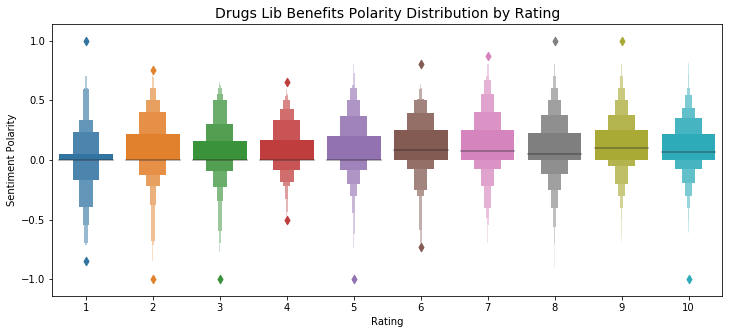

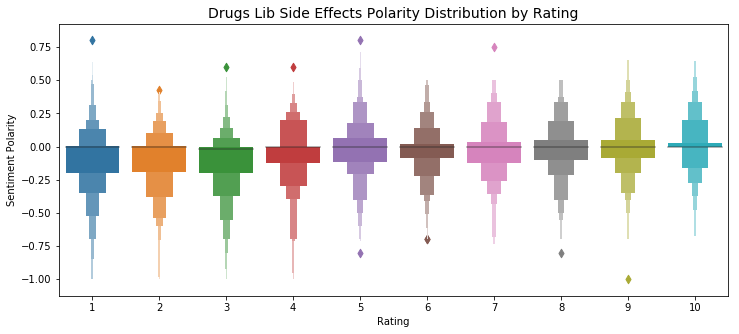

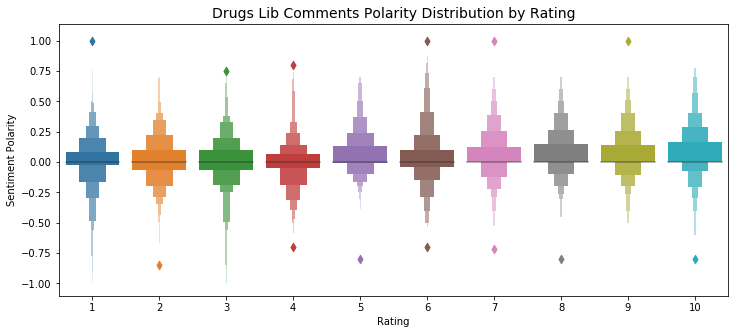

In [13]:
pol_by_rating(df_lib_full['rating'], df_lib_full['b_score_pol'], 'Drugs Lib Benefits Polarity Distribution by Rating')
pol_by_rating(df_lib_full['rating'], df_lib_full['se_score_pol'], 'Drugs Lib Side Effects Polarity Distribution by Rating')
pol_by_rating(df_lib_full['rating'], df_lib_full['c_score_pol'], 'Drugs Lib Comments Polarity Distribution by Rating')

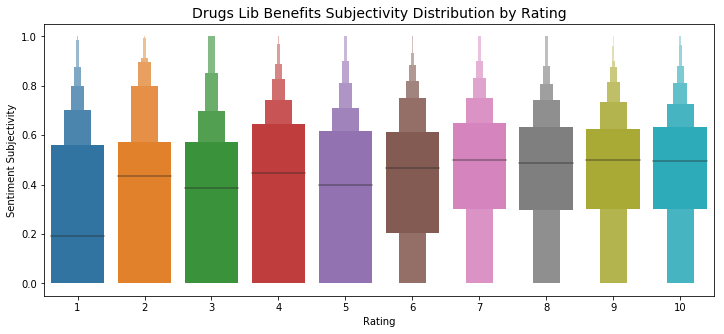

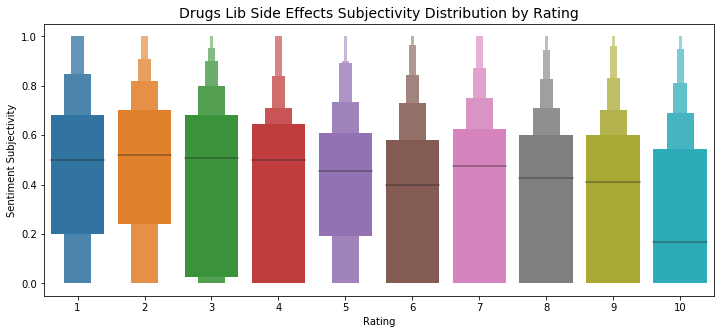

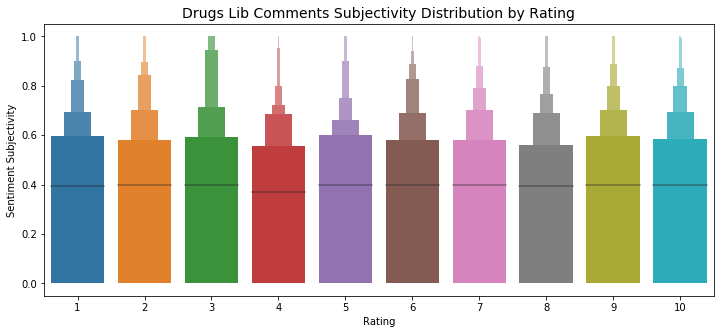

In [14]:
sub_by_rating(df_lib_full['rating'], df_lib_full['b_score_sub'], 'Drugs Lib Benefits Subjectivity Distribution by Rating')
sub_by_rating(df_lib_full['rating'], df_lib_full['se_score_sub'], 'Drugs Lib Side Effects Subjectivity Distribution by Rating')
sub_by_rating(df_lib_full['rating'], df_lib_full['c_score_sub'], 'Drugs Lib Comments Subjectivity Distribution by Rating')

For the Drugs Lib dataset, again as the rating increases so does the polarity score for the three different types of reviews. For the subjectivities the comments are all about the same, but the benefits and side effects have opposite trends. For benefits, the subjectivity increases as the rating increases. For the side effects, the subjectivity increases as the rating decreases.

#### Example

In [15]:
print('Benefits:\n{0}'.format(df_lib_full['benefitsReview'].loc[df_lib_full['b_score_sub']==1][757]))
print('\nSide Effects:\n{0}\nSubjectivity Score: {1:.2f}'.format(df_lib_full['sideEffectsReview'].iloc[757], df_lib_full['se_score_sub'].iloc[757]))
print('\nComments:\n{0}\nSubjectivity Score: {1:.2f} '.format(df_lib_full['commentsReview'].iloc[757], df_lib_full['c_score_sub'].iloc[757]))

Benefits:
I feel better about myself and less anxious and depressed.

Side Effects:












13. Very bad watery diarrhea after quitting (unless it was the flu)
Subjectivity Score: 0.57

Comments:
I first had a 60-mg shot in the office; the next day I was to take three 20-mg pills (=60 mg, once a day).  Then, for 5 days, I had to take two 20-mg pills; then for the last two days, I was to take one 20-mg pill each day.
Subjectivity Score: 0.00 


In the above example review, it can be seen that the more times words like feel or felt show up, then the higher the subjectivity score is. The benefits was totally subjective because it stated how the person felt. The comments was completely fact because it related to the exact dosages and times the drug was taken. The side effects comments showed a mixture between things that the patient felt along with facts about things that happened to the patient.

## Rating Deduction From Sentiment Polarity

A simple method to try to deduce the rating without using a machine learning tool is to simply divide the polarity scores into 10 equal bins to find a deduced rating. Also, one can ignore the exact rating value and try to understant negative, neutral and positive ratings and focus more on the positives and negatives to possibly make changes to the drug or administration of it.

In [16]:
# convert sentiment polarity to a rating value:
def deduce_rating(sent):
    if (sent<=1 and sent>0.8):
        sent_value = 10.0
    elif (sent<=0.8 and sent>0.6):
        sent_value = 9.0
    elif (sent<=0.6 and sent>0.4):
        sent_value = 8.0      
    elif (sent<=0.4 and sent>0.2):
        sent_value = 7.0
    elif (sent<=0.2 and sent>0):
        sent_value = 6.0
    elif (sent<=0 and sent>-0.2):
        sent_value = 5.0
    elif (sent<=-0.2 and sent>-0.4):
        sent_value = 4.0
    elif (sent<=-0.4 and sent>-0.6):
        sent_value = 3.0
    elif (sent<=-0.6 and sent>-0.8):
        sent_value = 2.0
    else:
        sent_value = 1.0
    return sent_value

In [17]:
# convert sentiment polarity to a qualitative text value:
def deduce_rating2(sent):
    if (sent<=1 and sent>0.33):
        sent_text = 'positive'
    elif (sent<=0. and sent>-0.33):
        sent_text = 'neutral'
    else:
        sent_text = 'negative'
    return sent_text

In [18]:
df_com_full['sent_rating'] = df_com_full['score_pol'].apply(deduce_rating)

df_lib_full['b_sent_rating'] = df_lib_full['b_score_pol'].apply(deduce_rating)
df_lib_full['se_sent_rating'] = df_lib_full['se_score_pol'].apply(deduce_rating)
df_lib_full['c_sent_rating'] = df_lib_full['c_score_pol'].apply(deduce_rating)

In [19]:
df_com_full['sent_text'] = df_com_full['score_pol'].apply(deduce_rating2)

df_lib_full['b_sent_text'] = df_lib_full['b_score_pol'].apply(deduce_rating2)
df_lib_full['se_sent_text'] = df_lib_full['se_score_pol'].apply(deduce_rating2)
df_lib_full['c_sent_text'] = df_lib_full['c_score_pol'].apply(deduce_rating2)

### Drugs.com Dataset

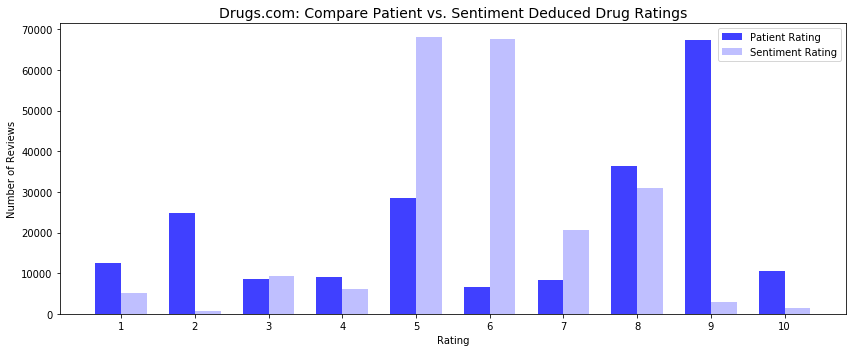

In [20]:
fig, ax = plt.subplots(figsize=(12,5))
width = 0.35

p1 = plt.bar(df_com_full['rating'].unique() - width/2, 
             df_com_full['rating'].value_counts(), 
             width, label = 'Patient Rating', color='b', alpha=0.75)

p3 = plt.bar(df_com_full['sent_rating'].unique() + width/2, 
             df_com_full['sent_rating'].value_counts(), 
             width, label = 'Sentiment Rating', color='b', alpha=0.25)

plt.title('Drugs.com: Compare Patient vs. Sentiment Deduced Drug Ratings', fontsize=14)
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Rating')
ax.set_xticks(df_com_full['rating'].unique())
ax.legend()
fig.tight_layout()

plt.show()

The barplot above shows the actual patient rating for the drug in dark blue and the deduced rating from the sentiment polarity in the light blue. Most of the bars do not closely match each other, therefore, using a sentiment polarity and equally dividing the polarity among ratings is not an effective method for predicting the total rating. Many more people gave higher ratings, with the distribution looking skewed to the right. However, as seen in the previous graphs, the polarity among reviews is approximately a normal distribution which correlates to this chart showing that most of the reviews had deduced ratings in the middle of the chart at 5 and 6.

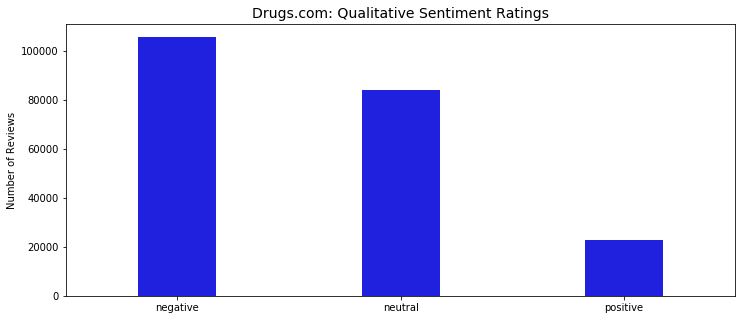

In [21]:
fig, ax = plt.subplots(figsize=(12,5))

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value) # change bar width
        patch.set_x(patch.get_x() + diff * 0.5) # recenter bar over xtick

order = ['negative', 'neutral', 'positive']
ax1 = sns.countplot(x='sent_text', data=df_com_full, ax=ax, order=order, color='blue')
change_width(ax1, 0.35)

plt.title('Drugs.com: Qualitative Sentiment Ratings', fontsize=14)
ax.set_ylabel('Number of Reviews')
ax.set_xlabel(None)
plt.show()

Again the normal distribution shows that most of the reviews are neutral while only a few are very positive or very negative in nature. However, this chart might help to pull out the most positive and the most negative reviews to help identify factors that could help escalate improvements to a drug or the administration of it.

### Drugs Lib Dataset

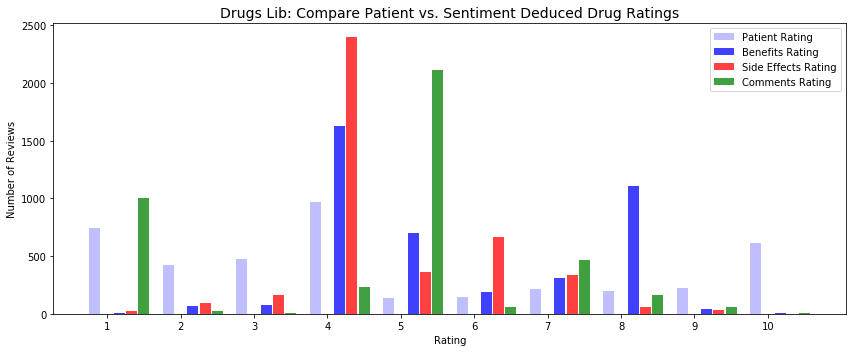

In [22]:
fig, ax = plt.subplots(figsize=(12,5))
width_s = 0.5
width_b = 0.15
p1 = plt.bar(df_lib_full['rating'].unique() - width_s/3, 
             df_lib_full['rating'].value_counts(), 
             width_b, label = 'Patient Rating', color='b', alpha = 0.25)

p3 = plt.bar(df_lib_full['b_sent_rating'].unique() + width_s/3, 
             df_lib_full['b_sent_rating'].value_counts(), 
             width_b, label = 'Benefits Rating', color='b', alpha = 0.75)


p5 = plt.bar(df_lib_full['se_sent_rating'].unique() + 2*width_s/3,
             df_lib_full['se_sent_rating'].value_counts(), 
             width_b, label = 'Side Effects Rating', color='r', alpha = 0.75)


p7 = plt.bar(df_lib_full['c_sent_rating'].unique() + width_s, 
             df_lib_full['c_sent_rating'].value_counts(), 
             width_b, label = 'Comments Rating', color='g', alpha = 0.75)


plt.title('Drugs Lib: Compare Patient vs. Sentiment Deduced Drug Ratings', fontsize=14)
ax.set_ylabel('Number of Reviews')
ax.set_xlabel('Rating')
ax.set_xticks(df_lib_full['rating'].unique())
ax.legend()
fig.tight_layout()

plt.show()

In the Drugs Lib dataset there are more neutral and negative patient ratings than there are in the Drugs.com dataset. The deduced ratings follow some of the actual patient ratings a little bit closer than in the other dataset, however, there is still no obvious pattern to extract and again, this method is not very accurate for a predictive analysis. A different kind of ML algorithm would probably be better at determining a rating based off a review.

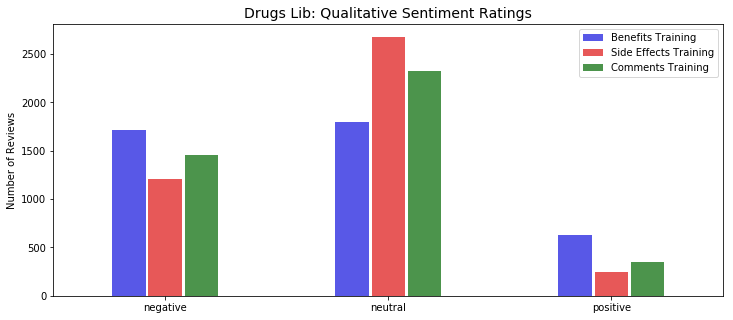

In [23]:
fig, ax = plt.subplots(figsize=(12,5))

def change_width(ax, new_value, shift) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + shift * diff * 0.5)
    return 

width = 0.15

order = ['negative', 'neutral', 'positive']

ax1 = sns.countplot(x='b_sent_text', data=df_lib_full, label='Benefits Training', ax=ax, order=order, color='blue', alpha=0.75)
change_width(ax1, width, 0.5)

ax2 = sns.countplot(x='se_sent_text', data=df_lib_full, label='Side Effects Training', ax=ax, order=order, color='red', alpha=0.75)
change_width(ax2, width, 1)

ax3 = sns.countplot(x='c_sent_text', data=df_lib_full, label='Comments Training', ax=ax, order=order, color='green', alpha=0.75)
change_width(ax3, width, 1.5)

plt.title('Drugs Lib: Qualitative Sentiment Ratings', fontsize=14)
ax.set_ylabel('Number of Reviews')
ax.set_xlabel(None)
ax.legend()
plt.show()

Most of the reviews are in the neutral category. However, the benefits reviews have more positive ratings and the side effects reviews have more negative ratings (as could be assumed).

# Save Sentimented Rated Datasets

In [24]:
with open('./reviews_with_sent_ratings.pk', 'wb') as f:
    pickle.dump(df_com_full, f)
    pickle.dump(df_com_full, f)